## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import cross_val_score

In [2]:
df_users = pd.read_csv("df_user.csv")
df_keys = pd.read_csv("df_keys.csv")

In [3]:
hold_by_user =  df_keys[df_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean'])
latency_by_user = df_keys[np.in1d(df_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['LatencyTime'].agg(['mean'])

In [4]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]

In [5]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]

In [6]:
combined = pd.concat([hold_by_user_flat, latency_by_user_flat], axis=1)

In [7]:
full_set = pd.merge(combined.reset_index(), df_users[['ID', 'Parkinsons']], on='ID')


In [8]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)

In [9]:
X = full_set.drop(columns=['Parkinsons', 'ID'], axis=1)
y = full_set['Parkinsons']

In [10]:
#save full_set
full_set.to_csv('full_set.csv', index=False)

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=42)
from sklearn.model_selection import cross_validate
rf.fit(X, y)
cv = cross_val_score(rf, X, y, cv=5)
print(cv.mean())

0.46911764705882353


In [12]:
#save model
filename = 'RandomForestClassifier.sav'
pickle.dump(rf, open(filename, 'wb'))

In [13]:
import shap

In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X)

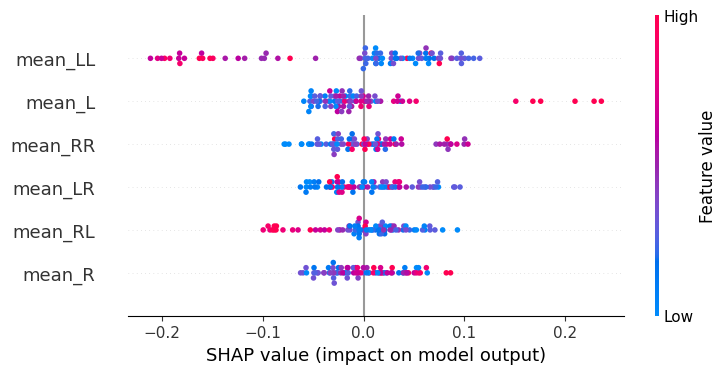

In [15]:
shap.initjs()
shap.plots.beeswarm(shap_values[:,:,1], max_display=27)

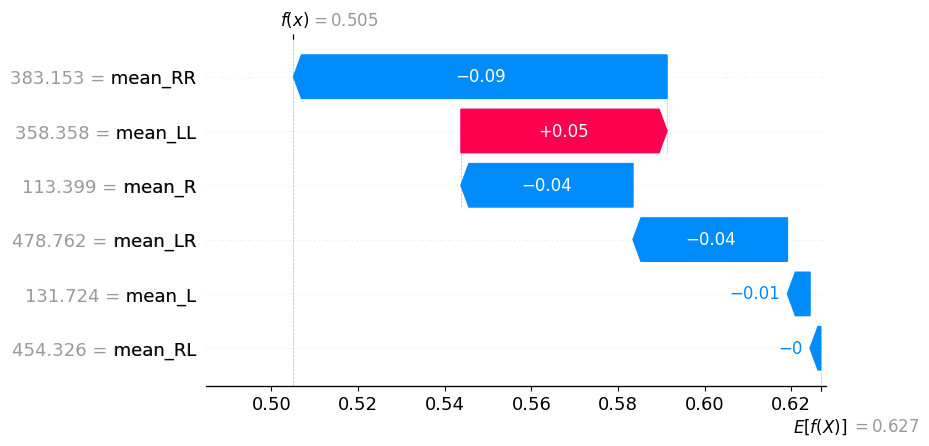

In [16]:
shap.plots.waterfall(shap_values[6,:,0], max_display=27)